In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

stock_prices_df = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
secondary_stock_prices_df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv')
supple_stock_prices_df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv')
stock_list_df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv')

In [2]:
stock_prices_df = stock_prices_df[stock_prices_df['Date'] >= '2020-04-01'].reset_index(drop=True)
stock_prices_df = pd.concat((stock_prices_df, supple_stock_prices_df)).reset_index(drop=True)
stock_prices_df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20200401_1301,2020-04-01,1301,2517.0,2557.0,2498.0,2517.0,56000,1.0,NaN,False,-0.006369
1,20200401_1332,2020-04-01,1332,454.0,456.0,431.0,435.0,8233600,1.0,NaN,False,0.009662
2,20200401_1333,2020-04-01,1333,2243.0,2296.0,2234.0,2251.0,355700,1.0,NaN,False,-0.020852
3,20200401_1376,2020-04-01,1376,1305.0,1325.0,1216.0,1261.0,8500,1.0,NaN,False,0.008045
4,20200401_1377,2020-04-01,1377,3250.0,3305.0,3115.0,3125.0,104100,1.0,NaN,False,-0.016234


# preprocess

In [3]:
IDX_BEGIN_FEATURE = 3

def df2Codedict(_df, is_values=False):
    df = _df.copy()
    dataset_dict = {}
    for sc in df['SecuritiesCode'].unique():
        if is_values:
             # "3:" means without [date, timestamp, code]
            dataset_dict[str(sc)] = df[df['SecuritiesCode'] == sc].values[:, IDX_BEGIN_FEATURE:].astype(np.float32)
        else:
            dataset_dict[str(sc)] = df[df['SecuritiesCode'] == sc].reset_index(drop=True)
    return dataset_dict

In [4]:
def cat_col(df):
    df['SecuritiesCode'] = df['SecuritiesCode'].astype('category')
    df['SupervisionFlag'] = df['SupervisionFlag'].astype('category')
    df['AdjustmentFactor'] = df['AdjustmentFactor'].astype('category')
    df['Month'] = df['Month'].astype('category')
    return df

def preprocess(_df, training=True):
    df = _df.copy()
    def get_month(dt):
        x = dt.strftime('%m')
        return x        
    
    def fillna_as_0(df):
        na_features_name = df.isnull().sum().index[df.isnull().sum() != 0]
        #df[na_features_name] = df[na_features_name].fillna(0)
        df[na_features_name] = df[na_features_name].interpolate(method='ffill')

        return df
    
    def as_float32(df):
        float_columns = df.describe().columns
        df[float_columns] = df[float_columns].astype('float32')
        return df

    def create_RSI(df):
        # 終値の差分
        df_diff = df['Close'].diff()
        
        # 値上がり幅と値下がり幅
        df_up, df_down = df_diff.copy(), df_diff.copy()
        df_up[df_up < 0] = 0
        df_down[df_down > 0] = 0
        df_down = df_down * -1
        
        # 14日間の単純移動平均
        sim14_up = df_up.rolling(window=14, min_periods=1).mean().fillna(method='bfill')
        sim14_down = df_down.rolling(window=14, min_periods=1).mean().fillna(method='bfill')
        # RSI
        return sim14_up / (sim14_up + sim14_down) * 100
    
    
    def create_base_features(df):
        # MA
        df['MA_5days'] = df['Close'].rolling(5, min_periods=1).mean().fillna(method='bfill')
        df['MA_25days'] = df['Close'].rolling(25, min_periods=1).mean().fillna(method='bfill')
        df['MA_75days'] = df['Close'].rolling(75, min_periods=1).mean().fillna(method='bfill')

        # MACD
        df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
        df['MACD'] = df['MACD'].fillna(method='bfill')
        df['Signal'] = df['MACD'].ewm(span=9).mean()
        df['Signal'] = df['Signal'].fillna(method='bfill')

        # bollinger_band
        df['Bollinger_band_upper'] = df['Close'].rolling(25, min_periods=1).mean() + 2*df['Close'].rolling(25, min_periods=1).std()
        df['Bollinger_band_upper'] = df['Bollinger_band_upper'].fillna(method='bfill')
        df['Bollinger_band_lower'] = df['Close'].rolling(25, min_periods=1).mean() - 2*df['Close'].rolling(25, min_periods=1).std()
        df['Bollinger_band_lower'] = df['Bollinger_band_lower'].fillna(method='bfill')
        
        # RSI
        df['RSI'] = create_RSI(df)
        
        return df
    
    def move_Target_to_last_row(df):
        # move target last row
        target_tmp = df['Target']
        df = df.drop('Target', axis=1)
        df['Target'] = target_tmp
        return df
    
    def create_diff(df):
        cols = df.describe().columns
        if 'Target' in cols:
            cols = cols.drop('Target')
        for _c in cols:
            df[_c + '_diff'] = df[_c].diff().fillna(method='bfill')
        return df

    df['ExpectedDividend'] = df['ExpectedDividend'].fillna(0)
    df['Date'] = pd.to_datetime(df['Date'], format = "%Y-%m-%d")
    df['SupervisionFlag'] = df['SupervisionFlag'].map({True: 1, False: 0})
    df['Month'] =  list(map(get_month, df['Date']))
    df['SecuritiesCode_int'] = df['SecuritiesCode'].astype('float32')
    df = cat_col(df)
    df = create_base_features(df)
    #df = fillna_as_0(df)
    df = create_diff(df)
    df = df.interpolate(method='ffill')
    df = as_float32(df)

    if training:
        df = move_Target_to_last_row(df)
    
    return df

In [5]:
stock_prices_dict = df2Codedict(stock_prices_df)
#secondary_stock_prices_dict = df2Codedict(secondary_stock_prices_df)

#stock_prices_dict.update(secondary_stock_prices_dict)

#supple_stock_prices_dict = df2Codedict(supple_stock_prices_df)

In [6]:
from tqdm import tqdm

stock_prices_proced_df = []
supple_stock_prices_proced_df = []
for code, df in tqdm(stock_prices_dict.items()):
    stock_prices_proced_df.append(preprocess(df))

#for code, df in tqdm(supple_stock_prices_dict.items()):
#    supple_stock_prices_proced_df.append(preprocess(df))
    
stock_prices_proced_df = pd.concat(stock_prices_proced_df).reset_index(drop=True)
stock_prices_proced_df = cat_col(stock_prices_proced_df).interpolate(method='ffill')
#supple_stock_prices_proced_df = pd.concat(supple_stock_prices_proced_df).reset_index(drop=True)
#supple_stock_prices_proced_df= cat_col(supple_stock_prices_proced_df)

100%|██████████| 2000/2000 [04:14<00:00,  7.86it/s]


In [7]:
def NA_counter(x_df):
    n_nan = x_df.isnull().sum()
    x_df_dtype = x_df.dtypes
    percent_nan = n_nan/len(x_df)*100
    display(pd.DataFrame([n_nan, percent_nan,x_df_dtype]).rename({0:'n_nan', 1:'%', 2:'dtype'})) 
    
NA_counter(stock_prices_proced_df)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,SecuritiesCode_int_diff,MA_5days_diff,MA_25days_diff,MA_75days_diff,MACD_diff,Signal_diff,Bollinger_band_upper_diff,Bollinger_band_lower_diff,RSI_diff,Target
n_nan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dtype,object,datetime64[ns],category,float32,float32,float32,float32,float32,category,float32,...,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32


In [8]:
stock_prices_proced_df.describe().columns.drop(['Target'])

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'ExpectedDividend',
       'SecuritiesCode_int', 'MA_5days', 'MA_25days', 'MA_75days', 'MACD',
       'Signal', 'Bollinger_band_upper', 'Bollinger_band_lower', 'RSI',
       'Open_diff', 'High_diff', 'Low_diff', 'Close_diff', 'Volume_diff',
       'ExpectedDividend_diff', 'SecuritiesCode_int_diff', 'MA_5days_diff',
       'MA_25days_diff', 'MA_75days_diff', 'MACD_diff', 'Signal_diff',
       'Bollinger_band_upper_diff', 'Bollinger_band_lower_diff', 'RSI_diff'],
      dtype='object')

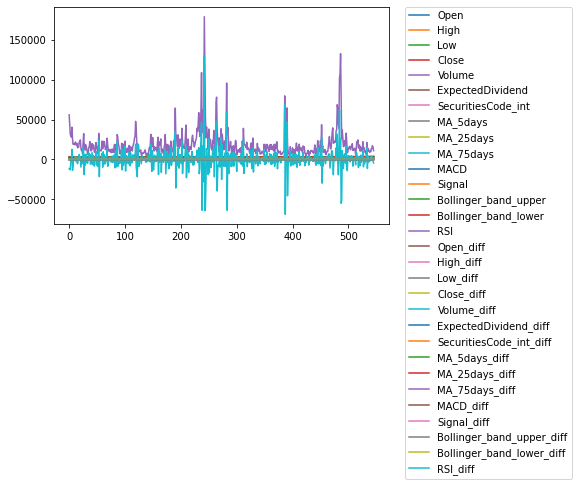

In [9]:
stock_prices_proced_df[stock_prices_proced_df.SecuritiesCode==1301].iloc[:, 3:-1].plot().legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [10]:
stock_prices_proced_df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,SecuritiesCode_int_diff,MA_5days_diff,MA_25days_diff,MA_75days_diff,MACD_diff,Signal_diff,Bollinger_band_upper_diff,Bollinger_band_lower_diff,RSI_diff,Target
0,20200401_1301,2020-04-01,1301,2517.0,2557.0,2498.0,2517.0,56000.0,1.0,0.0,...,0.0,-2.500000,-2.500000,-2.500000,-0.112179,-0.062322,0.000000,0.000000,0.000000,-0.006369
1,20200402_1301,2020-04-02,1301,2467.0,2539.0,2446.0,2512.0,44400.0,1.0,0.0,...,0.0,-2.500000,-2.500000,-2.500000,-0.112179,-0.062322,0.000000,0.000000,0.000000,0.003205
2,20200403_1301,2020-04-03,1301,2481.0,2530.0,2456.0,2496.0,31300.0,1.0,0.0,...,0.0,-6.166667,-6.166667,-6.166667,-0.526918,-0.236384,8.701575,-21.034908,0.000000,0.020367
3,20200406_1301,2020-04-06,1301,2450.0,2527.0,2450.0,2504.0,29600.0,1.0,0.0,...,0.0,-1.083333,-1.083333,-1.083333,0.064847,-0.093342,-4.592596,2.425929,27.586206,0.016438
4,20200407_1301,2020-04-07,1301,2550.0,2560.0,2495.0,2555.0,27900.0,1.0,0.0,...,0.0,9.550000,9.550000,9.550000,2.076734,0.563580,36.713810,-17.613811,46.163792,-0.016943


In [11]:
stock_prices_proced_df.describe()

,Open,High,Low,Close,Volume,ExpectedDividend,SecuritiesCode_int,MA_5days,MA_25days,MA_75days,...,SecuritiesCode_int_diff,MA_5days_diff,MA_25days_diff,MA_75days_diff,MACD_diff,Signal_diff,Bollinger_band_upper_diff,Bollinger_band_lower_diff,RSI_diff,Target
count,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,...,1088589.0,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06
mean,2.690890e+03,2.725683e+03,2.653543e+03,2.689580e+03,6.275229e+05,1.796051e-01,5.884955e+03,2.688090e+03,2.680752e+03,2.666994e+03,...,0.0,6.842468e-01,8.067255e-01,8.460906e-01,-4.110581e-02,-2.758549e-02,1.085584e+00,6.425350e-01,5.461500e-02,8.187441e-04
std,4.140721e+03,4.193664e+03,4.084723e+03,4.139025e+03,2.799596e+06,4.033189e+00,2.391120e+03,4.134573e+03,4.114109e+03,4.066250e+03,...,0.0,6.123282e+01,2.650196e+01,1.613015e+01,1.735924e+01,1.126539e+01,5.697932e+01,5.141582e+01,7.241444e+00,2.397462e-02
min,1.500000e+01,1.500000e+01,1.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00,1.301000e+03,1.520000e+01,1.650000e+01,1.650000e+01,...,0.0,-4.822000e+03,-1.176000e+03,-7.360000e+02,-1.759233e+03,-8.036372e+02,-8.483252e+03,-6.836779e+03,-1.000000e+02,-5.249042e-01
25%,1.012000e+03,1.025000e+03,1.000000e+03,1.012000e+03,3.240000e+04,0.000000e+00,3.915000e+03,1.012200e+03,1.010560e+03,1.006387e+03,...,0.0,-7.800000e+00,-3.080000e+00,-1.486486e+00,-2.285787e+00,-1.491373e+00,-3.864908e+00,-3.592867e+00,-4.021650e+00,-1.138952e-02
50%,1.800000e+03,1.822000e+03,1.776000e+03,1.800000e+03,1.030000e+05,0.000000e+00,6.201000e+03,1.799000e+03,1.793760e+03,1.785757e+03,...,0.0,2.000000e-01,2.750000e-01,2.933333e-01,3.716183e-02,6.267681e-02,1.303729e-02,1.142375e-01,0.000000e+00,0.000000e+00
75%,3.020000e+03,3.060000e+03,2.983000e+03,3.020000e+03,3.808000e+05,0.000000e+00,7.943000e+03,3.019000e+03,3.016440e+03,3.005040e+03,...,0.0,9.000000e+00,4.400000e+00,2.826503e+00,2.415290e+00,1.613592e+00,4.717996e+00,4.706889e+00,4.023756e+00,1.187335e-02
max,1.099500e+05,1.105000e+05,1.072000e+05,1.095500e+05,3.333562e+08,1.080000e+03,9.997000e+03,1.068600e+05,9.999720e+04,9.347413e+04,...,0.0,5.260000e+03,1.740000e+03,1.500659e+03,1.772074e+03,6.628093e+02,6.452478e+03,6.690052e+03,1.000000e+02,6.182380e-01


In [12]:
stock_prices_proced_df.describe().columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'ExpectedDividend',
       'SecuritiesCode_int', 'MA_5days', 'MA_25days', 'MA_75days', 'MACD',
       'Signal', 'Bollinger_band_upper', 'Bollinger_band_lower', 'RSI',
       'Open_diff', 'High_diff', 'Low_diff', 'Close_diff', 'Volume_diff',
       'ExpectedDividend_diff', 'SecuritiesCode_int_diff', 'MA_5days_diff',
       'MA_25days_diff', 'MA_75days_diff', 'MACD_diff', 'Signal_diff',
       'Bollinger_band_upper_diff', 'Bollinger_band_lower_diff', 'RSI_diff',
       'Target'],
      dtype='object')

In [13]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

code2robustsc = {}
code2stdsc = {}

catsc = MinMaxScaler(feature_range=[-0.5, 0.5])
categorical_columns = ['AdjustmentFactor', 'SecuritiesCode_int', 'SupervisionFlag', 'Month']
stock_prices_proced_df.loc[:, categorical_columns] = catsc.fit_transform(stock_prices_proced_df[categorical_columns])

for code, data in tqdm(stock_prices_proced_df.groupby('SecuritiesCode')):
    robustsc = RobustScaler(quantile_range=[0.25, 0.75], unit_variance=True)
    stdsc = StandardScaler()
    columns = stock_prices_proced_df.columns.drop(['RowId','SecuritiesCode', 'Date','Target'] + categorical_columns)
    #columns = stock_prices_proced_df.columns.drop(['RowId','SecuritiesCode', 'Date','Target'])
    value = robustsc.fit_transform(stock_prices_proced_df[stock_prices_proced_df.SecuritiesCode == code][columns])
    value = stdsc.fit_transform(value)
    stock_prices_proced_df.loc[stock_prices_proced_df.SecuritiesCode == code, columns] = value
    code2robustsc[code] = robustsc
    code2stdsc[code] = stdsc
    
stock_prices_proced_df.head()

100%|██████████| 2000/2000 [02:20<00:00, 14.20it/s]


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,SecuritiesCode_int_diff,MA_5days_diff,MA_25days_diff,MA_75days_diff,MACD_diff,Signal_diff,Bollinger_band_upper_diff,Bollinger_band_lower_diff,RSI_diff,Target
0,20200401_1301,2020-04-01,1301,-2.077562,-1.970980,-2.073439,-2.071934,2.245799,-0.418367,-0.060499,...,0.0,-0.329406,-0.965131,-1.867629,-0.043854,-0.048844,-0.176678,-0.198617,-0.013380,-0.006369
1,20200402_1301,2020-04-02,1301,-2.305423,-2.052332,-2.311268,-2.094678,1.542452,-0.418367,-0.060499,...,0.0,-0.329406,-0.965131,-1.867629,-0.043854,-0.048844,-0.176678,-0.198617,-0.013380,0.003205
2,20200403_1301,2020-04-03,1301,-2.241621,-2.093008,-2.265531,-2.167458,0.748155,-0.418367,-0.060499,...,0.0,-0.623877,-1.840971,-3.595258,-0.159131,-0.132774,0.736462,-3.149829,-0.013380,0.020367
3,20200406_1301,2020-04-06,1301,-2.382895,-2.106567,-2.292973,-2.131068,0.645079,-0.418367,-0.060499,...,0.0,-0.215632,-0.626738,-1.200136,0.005351,-0.063802,-0.658623,0.141742,3.819734,0.016438
4,20200407_1301,2020-04-07,1301,-1.927174,-1.957421,-2.087160,-1.899079,0.542002,-0.418367,-0.060499,...,0.0,0.638336,1.913200,3.809989,0.564557,0.252954,3.676057,-2.669847,6.401097,-0.016943


In [14]:
stock_prices_proced_df.describe()

,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Month,SecuritiesCode_int,...,SecuritiesCode_int_diff,MA_5days_diff,MA_25days_diff,MA_75days_diff,MACD_diff,Signal_diff,Bollinger_band_upper_diff,Bollinger_band_lower_diff,RSI_diff,Target
count,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,...,1088589.0,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06,1.088589e+06
mean,-4.205110e-10,8.830732e-10,1.822214e-10,2.943577e-10,-4.029897e-10,-4.183697e-01,3.905715e-09,-4.991117e-01,-7.964480e-03,2.713362e-02,...,0.0,-1.138884e-10,-5.256388e-11,-2.838449e-10,-9.286285e-11,-1.401703e-10,1.226490e-10,1.357900e-10,3.539301e-10,8.187441e-04
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.146136e-03,9.619980e-01,2.979123e-02,3.004091e-01,2.749678e-01,...,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.397462e-02
min,-1.209774e+01,-1.234076e+01,-1.200800e+01,-1.229264e+01,-2.815017e+00,-5.000000e-01,-1.219421e-01,-5.000000e-01,-5.000000e-01,-5.000000e-01,...,0.0,-1.252078e+01,-1.361871e+01,-1.597720e+01,-1.434562e+01,-8.315035e+00,-1.745269e+01,-1.950581e+01,-1.200140e+01,-5.249042e-01
25%,-7.575684e-01,-7.592817e-01,-7.564673e-01,-7.578545e-01,-5.216084e-01,-4.183673e-01,-8.568364e-02,-5.000000e-01,-2.272727e-01,-1.994020e-01,...,0.0,-5.263193e-01,-5.543464e-01,-5.291045e-01,-5.149607e-01,-5.398946e-01,-3.737924e-01,-3.690741e-01,-5.681202e-01,-1.138952e-02
50%,-9.038254e-03,-1.376655e-02,-2.617173e-03,-9.441175e-03,-2.364997e-01,-4.183673e-01,-8.187739e-02,-5.000000e-01,-4.545455e-02,6.347746e-02,...,0.0,-8.020247e-03,-1.019006e-02,-1.453420e-02,1.311874e-02,2.996466e-02,-3.998606e-02,-1.652048e-02,-8.572795e-03,0.000000e+00
75%,7.188737e-01,7.173188e-01,7.222195e-01,7.187108e-01,2.142898e-01,-4.183673e-01,-6.055993e-02,-5.000000e-01,2.272727e-01,2.637994e-01,...,0.0,5.263638e-01,5.518146e-01,5.240677e-01,5.409962e-01,5.720488e-01,3.196820e-01,3.677750e-01,5.532297e-01,1.187335e-02
max,1.977772e+01,1.974047e+01,1.976860e+01,1.972392e+01,2.261442e+01,5.000000e-01,2.334524e+01,5.000000e-01,5.000000e-01,5.000000e-01,...,0.0,1.217413e+01,1.209318e+01,1.753051e+01,1.448876e+01,9.131392e+00,1.955593e+01,1.664135e+01,1.236550e+01,6.182380e-01


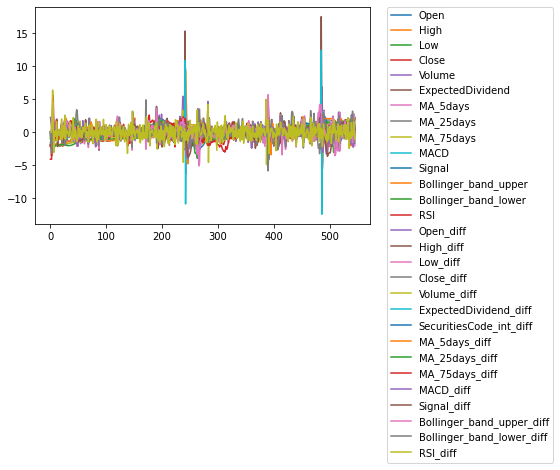

In [15]:
stock_prices_proced_df[stock_prices_proced_df.SecuritiesCode==1301].loc[:, columns].plot().legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [16]:
stock_prices_proced_df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,SecuritiesCode_int_diff,MA_5days_diff,MA_25days_diff,MA_75days_diff,MACD_diff,Signal_diff,Bollinger_band_upper_diff,Bollinger_band_lower_diff,RSI_diff,Target
0,20200401_1301,2020-04-01,1301,-2.077562,-1.970980,-2.073439,-2.071934,2.245799,-0.418367,-0.060499,...,0.0,-0.329406,-0.965131,-1.867629,-0.043854,-0.048844,-0.176678,-0.198617,-0.013380,-0.006369
1,20200402_1301,2020-04-02,1301,-2.305423,-2.052332,-2.311268,-2.094678,1.542452,-0.418367,-0.060499,...,0.0,-0.329406,-0.965131,-1.867629,-0.043854,-0.048844,-0.176678,-0.198617,-0.013380,0.003205
2,20200403_1301,2020-04-03,1301,-2.241621,-2.093008,-2.265531,-2.167458,0.748155,-0.418367,-0.060499,...,0.0,-0.623877,-1.840971,-3.595258,-0.159131,-0.132774,0.736462,-3.149829,-0.013380,0.020367
3,20200406_1301,2020-04-06,1301,-2.382895,-2.106567,-2.292973,-2.131068,0.645079,-0.418367,-0.060499,...,0.0,-0.215632,-0.626738,-1.200136,0.005351,-0.063802,-0.658623,0.141742,3.819734,0.016438
4,20200407_1301,2020-04-07,1301,-1.927174,-1.957421,-2.087160,-1.899079,0.542002,-0.418367,-0.060499,...,0.0,0.638336,1.913200,3.809989,0.564557,0.252954,3.676057,-2.669847,6.401097,-0.016943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088584,20220620_4169,2022-06-20,4169,-1.073720,-1.032769,-1.074121,-1.027399,3.409931,-0.418367,0.000000,...,0.0,0.292572,0.202757,0.044325,0.275075,0.203014,0.258427,-0.075718,1.100700,0.180058
1088585,20220621_4169,2022-06-21,4169,-1.002376,-0.962337,-0.992813,-0.949386,5.537711,-0.418367,0.000000,...,0.0,0.484561,0.295873,0.055767,0.508479,0.313429,0.466670,-0.241691,1.316251,-0.114028
1088586,20220622_4169,2022-06-22,4169,-0.913455,-0.816054,-0.929935,-0.852651,12.251432,-0.418367,0.000000,...,0.0,0.598431,0.396792,0.027412,0.759241,0.475735,0.710782,-0.447413,0.803813,0.050000
1088587,20220623_4169,2022-06-23,4169,-0.898462,-0.833293,-0.946739,-0.924943,7.846936,-0.418367,0.000000,...,0.0,0.399821,0.326044,0.081137,0.280864,0.464461,0.348612,-0.035169,-1.555582,0.231041


In [17]:
stock_prices_proced_dict = df2Codedict(stock_prices_proced_df, is_values=True)
#supple_stock_prices_proced_dict = df2Codedict(supple_stock_prices_proced_df, is_values=True)

## LSTM

In [18]:
stock_prices_proced_df.columns[IDX_BEGIN_FEATURE:-1]

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor',
       'ExpectedDividend', 'SupervisionFlag', 'Month', 'SecuritiesCode_int',
       'MA_5days', 'MA_25days', 'MA_75days', 'MACD', 'Signal',
       'Bollinger_band_upper', 'Bollinger_band_lower', 'RSI', 'Open_diff',
       'High_diff', 'Low_diff', 'Close_diff', 'Volume_diff',
       'ExpectedDividend_diff', 'SecuritiesCode_int_diff', 'MA_5days_diff',
       'MA_25days_diff', 'MA_75days_diff', 'MACD_diff', 'Signal_diff',
       'Bollinger_band_upper_diff', 'Bollinger_band_lower_diff', 'RSI_diff'],
      dtype='object')

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input_size = len(stock_prices_proced_df.columns[IDX_BEGIN_FEATURE:-1]) 

class LSTM(nn.Module):
    def __init__(self, input_size=input_size, sequence_num=31, lstm_dim=128,
                 num_layers=2, output_size=1):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, lstm_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        self.linear1 = nn.Linear(lstm_dim*sequence_num*2, 1)
        self.bn1 = nn.BatchNorm1d(lstm_dim*sequence_num*2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out.reshape(lstm_out.shape[0], -1)
        #x = self.linear1(x)
        x = self.linear1(self.bn1(x))
        return x

## dataloader

In [20]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import os

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, sequence_num=31, y=None, mode='train'):
        self.data = X
        self.teacher = y
        self.sequence_num = sequence_num
        self.mode = mode
        
    def __len__(self):
        return len(self.teacher)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        if self.mode == 'train':
            out_label =  self.teacher[idx[-1]]
            return out_data, out_label
        else:
            return out_data
        
def create_dataloader(dataset, dataset_num, sequence_num=31, input_size=input_size, batch_size=32, shuffle=False):
    sampler = np.array([list(range(i, i+sequence_num)) for i in range(dataset_num-sequence_num+1)])
    if shuffle == True:
        np.random.shuffle(sampler)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler, num_workers=os.cpu_count(), pin_memory=True)
    return dataloader

#### Check operation ####
X_check, y_check = stock_prices_proced_dict['1301'][:, :-1], stock_prices_proced_dict['1301'][:, -1]
dataset_check = MyDataset(X_check, y=y_check, sequence_num=31, mode='train')
dataloader_check = create_dataloader(dataset_check, X_check.shape[0], sequence_num=31, input_size=input_size, batch_size=32, shuffle=False)
for b, tup in enumerate(dataloader_check):
    print('---------')
    print(tup[0].shape, tup[1].shape)
    break

---------
torch.Size([32, 31, 33]) torch.Size([32])


In [21]:
epochs = 40
LR_MAX = 1e-3
LR_MIN = 1e-5
WARMUP_EPOCH = 10
START_ANNEALING_EPOCH = 10
END_ANNEALING_EPOCH = epochs
VISIBLE = True

batch_size = 500


def __warmup(epoch, warmup_epoch, warmup_rate, lr_end, visible=False):
    warmup_grad = warmup_rate / warmup_epoch
    if epoch <= warmup_epoch:
        lr = lr_end * 10**(-warmup_rate + warmup_grad*epoch)
    if visible:
        print('lr : {}'.format(lr))
        return lr
    else:
        return lr

def __cosine_annealing(epoch, lr_max, lr_min, epoch_start, epoch_end, visible=False):
    if epoch <= epoch_start:
        # before annealing
        return lr_max
    elif epoch_start < epoch <= epoch_end:
        # during annealing
        lr = lr_min + 0.5*(lr_max - lr_min)*(1+np.cos(np.pi*(epoch-epoch_start)/(epoch_end - epoch_start)))
        if visible:
            print('lr : {}'.format(lr))
        return lr
    else:
        # after annealing
        return lr

def update_lr(epoch):
    visible = VISIBLE
    warmup_epoch = 10
    if epoch <= warmup_epoch:
        lr = __warmup(epoch, warmup_epoch=WARMUP_EPOCH, warmup_rate=2.0, lr_end=LR_MAX, visible=visible)
    else:
        lr = __cosine_annealing(epoch,
                                lr_max=LR_MAX,
                                lr_min=LR_MIN,
                                epoch_start=START_ANNEALING_EPOCH,
                                epoch_end=END_ANNEALING_EPOCH,
                                visible=visible)
    return lr

In [22]:
from tqdm import tqdm

# Check wheter GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Model Instantiation
model = LSTM(input_size=X_check.shape[-1], sequence_num=31, lstm_dim=128, num_layers=2, output_size=1)
print('params size : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
model.to(device)

# setting optimizer
weight_decay = 1e-05
optimizer = torch.optim.AdamW(model.parameters(), lr=LR_MIN, weight_decay=weight_decay)
# setting criterion
criterion = nn.MSELoss()
# set iteration counter
iteration = 0
iteration_valid = 0
# 
log_train = [[0], [np.inf]]
#log_valid = [[0], [np.inf]]

lr_log = []
for epoch in range(epochs):
    # update lr
    for g in optimizer.param_groups:
        lr = update_lr(epoch)
        g['lr'] = lr
        lr_log.append(lr)
    
    # train
    epoch_loss = 0.0
    model.train()
    for sc in tqdm(stock_prices_df['SecuritiesCode'].unique()):
        X, y = stock_prices_proced_dict[str(sc)][:, :-1], stock_prices_proced_dict[str(sc)][:, -1]
        dataset = MyDataset(X, y=y, sequence_num=31, mode='train')
        # 銘柄ごとにデータローダーが作られる
        dataloader = create_dataloader(dataset, X.shape[0], sequence_num=31, input_size=input_size, batch_size=batch_size, shuffle=True)
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            data = data.to(torch.float32)
            output = model.forward(data)
            targets = targets.to(torch.float32)
            loss = criterion(output.view(1,-1)[0], targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            iteration += 1
    
    # valid 
#     epoch_loss_valid = 0.0
#     model.eval()
#     with torch.no_grad():
#         for sc in tqdm(supple_stock_prices_df['SecuritiesCode'].unique()):
#             X, y = supple_stock_prices_proced_dict[str(sc)][:, :-1], supple_stock_prices_proced_dict[str(sc)][:, -1]
#             dataset = MyDataset(X, y=y, sequence_num=31, mode='train')
#             # 銘柄ごとにデータローダーが作られる
#             dataloader = create_dataloader(dataset, X.shape[0], sequence_num=31, input_size=8, batch_size=batch_size, shuffle=False)
#             for data, targets in dataloader:
#                 data, targets = data.to(device), targets.to(device)
#                 data = data.to(torch.float32)
#                 output = model.forward(data)
#                 targets = targets.to(torch.float32)
#                 loss = criterion(output.view(1,-1)[0], targets)
#                 epoch_loss_valid += loss.item()
#                 iteration_valid += 1
                
    
    epoch_loss /= iteration
#    epoch_loss_valid /= iteration_valid
    print('train epoch_loss={}'.format(epoch_loss))
#    print('valid epoch_loss={}'.format(epoch_loss_valid))

    
    #log_train[0].append(iteration)
    log_train[0].append(epoch)
    log_train[1].append(epoch_loss)
#    log_valid[0].append(epoch)
#    log_valid[1].append(epoch_loss_valid)

model.eval()

params size :  585985
lr : 1e-05


100%|██████████| 2000/2000 [05:50<00:00,  5.71it/s]


train epoch_loss=0.03352857169423074
lr : 1.5848931924611134e-05


100%|██████████| 2000/2000 [05:54<00:00,  5.65it/s]


train epoch_loss=0.004514743174119531
lr : 2.5118864315095795e-05


100%|██████████| 2000/2000 [05:59<00:00,  5.56it/s]


train epoch_loss=0.001103915582365246
lr : 3.9810717055349735e-05


100%|██████████| 2000/2000 [06:00<00:00,  5.55it/s]


train epoch_loss=0.00044639915267770326
lr : 6.309573444801933e-05


100%|██████████| 2000/2000 [06:03<00:00,  5.50it/s]


train epoch_loss=0.00028620415031062487
lr : 0.0001


100%|██████████| 2000/2000 [05:55<00:00,  5.63it/s]


train epoch_loss=0.0002956763238807102
lr : 0.00015848931924611142


100%|██████████| 2000/2000 [05:57<00:00,  5.60it/s]


train epoch_loss=0.0004934409852123104
lr : 0.00025118864315095806


100%|██████████| 2000/2000 [05:58<00:00,  5.58it/s]


train epoch_loss=0.0007215338430459926
lr : 0.0003981071705534973


100%|██████████| 2000/2000 [05:59<00:00,  5.56it/s]


train epoch_loss=0.002159227082286415
lr : 0.0006309573444801934


100%|██████████| 2000/2000 [06:00<00:00,  5.55it/s]


train epoch_loss=0.003516357313388236
lr : 0.001


100%|██████████| 2000/2000 [06:01<00:00,  5.53it/s]


train epoch_loss=0.0028426886728098308
lr : 0.0009972883382072953


100%|██████████| 2000/2000 [06:03<00:00,  5.51it/s]


train epoch_loss=0.00023015014322809476
lr : 0.0009891830623632338


100%|██████████| 2000/2000 [05:55<00:00,  5.62it/s]


train epoch_loss=0.00010973853773964231
lr : 0.0009757729755661011


100%|██████████| 2000/2000 [05:56<00:00,  5.61it/s]


train epoch_loss=4.904652330819325e-05
lr : 0.0009572050015330874


100%|██████████| 2000/2000 [05:52<00:00,  5.68it/s]


train epoch_loss=3.690814119888726e-05
lr : 0.0009336825748732972


100%|██████████| 2000/2000 [06:02<00:00,  5.51it/s]


train epoch_loss=3.420658189037011e-05
lr : 0.000905463412215599


100%|██████████| 2000/2000 [05:54<00:00,  5.63it/s]


train epoch_loss=3.177287318891293e-05
lr : 0.0008728566886113102


100%|██████████| 2000/2000 [06:06<00:00,  5.45it/s]


train epoch_loss=3.05476772191489e-05
lr : 0.0008362196501476349


100%|██████████| 2000/2000 [05:55<00:00,  5.62it/s]


train epoch_loss=2.867924168212055e-05
lr : 0.0007959536998847742


100%|██████████| 2000/2000 [06:05<00:00,  5.47it/s]


train epoch_loss=2.7940193730419724e-05
lr : 0.0007525


100%|██████████| 2000/2000 [06:02<00:00,  5.51it/s]


train epoch_loss=2.6010815050338222e-05
lr : 0.0007063346383225212


100%|██████████| 2000/2000 [06:06<00:00,  5.46it/s]


train epoch_loss=2.5000531625697848e-05
lr : 0.000657963412215599


100%|██████████| 2000/2000 [06:00<00:00,  5.54it/s]


train epoch_loss=2.3368859384176567e-05
lr : 0.0006079162869547908


100%|██████████| 2000/2000 [06:09<00:00,  5.41it/s]


train epoch_loss=2.223170575067262e-05
lr : 0.0005567415893174885


100%|██████████| 2000/2000 [06:01<00:00,  5.54it/s]


train epoch_loss=2.1497487772763584e-05
lr : 0.0005050000000000001


100%|██████████| 2000/2000 [06:02<00:00,  5.51it/s]


train epoch_loss=2.0400521335893663e-05
lr : 0.00045325841068251166


100%|██████████| 2000/2000 [05:53<00:00,  5.65it/s]


train epoch_loss=1.9539804815786664e-05
lr : 0.0004020837130452091


100%|██████████| 2000/2000 [05:53<00:00,  5.65it/s]


train epoch_loss=1.862021451493349e-05
lr : 0.0003520365877844011


100%|██████████| 2000/2000 [06:04<00:00,  5.49it/s]


train epoch_loss=1.8186615769958533e-05
lr : 0.000303665361677479


100%|██████████| 2000/2000 [05:54<00:00,  5.64it/s]


train epoch_loss=1.7462598615108674e-05
lr : 0.00025750000000000013


100%|██████████| 2000/2000 [05:54<00:00,  5.64it/s]


train epoch_loss=1.7138144421463318e-05
lr : 0.00021404630011522585


100%|██████████| 2000/2000 [06:05<00:00,  5.48it/s]


train epoch_loss=1.620262524215889e-05
lr : 0.00017378034985236535


100%|██████████| 2000/2000 [05:57<00:00,  5.60it/s]


train epoch_loss=1.5778436808693258e-05
lr : 0.00013714331138868995


100%|██████████| 2000/2000 [05:56<00:00,  5.61it/s]


train epoch_loss=1.5144128947033944e-05
lr : 0.00010453658778440107


100%|██████████| 2000/2000 [05:56<00:00,  5.61it/s]


train epoch_loss=1.4599856577612067e-05
lr : 7.631742512670284e-05


100%|██████████| 2000/2000 [06:09<00:00,  5.41it/s]


train epoch_loss=1.4293839120003285e-05
lr : 5.279499846691251e-05


100%|██████████| 2000/2000 [05:57<00:00,  5.60it/s]


train epoch_loss=1.3750650494013811e-05
lr : 3.4227024433899005e-05


100%|██████████| 2000/2000 [05:57<00:00,  5.60it/s]


train epoch_loss=1.340587842186242e-05
lr : 2.0816937636766185e-05


100%|██████████| 2000/2000 [06:01<00:00,  5.53it/s]


train epoch_loss=1.3108945180965686e-05
lr : 1.2711661792704668e-05


100%|██████████| 2000/2000 [06:11<00:00,  5.38it/s]

train epoch_loss=1.283652957462842e-05


LSTM(
  (lstm): LSTM(33, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (linear1): Linear(in_features=7936, out_features=1, bias=True)
  (bn1): BatchNorm1d(7936, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

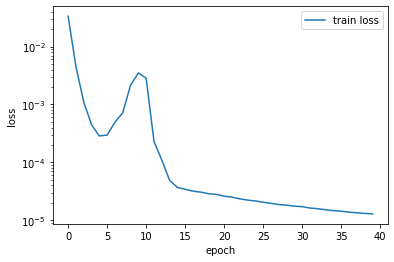

In [23]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(log_train[0][1:], log_train[1][1:], label='train loss')
#plt.plot(log_valid[0][1:], log_valid[1][1:], label='valid loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.yscale('log')
plt.show()

In [24]:
import jpx_tokyo_market_prediction

env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()


# try
#N_DAYS_PREPROCESS = 50
N_DAYS_PREPROCESS = 120
model.eval()
train_dict_base = stock_prices_dict.copy()
cnt_days = 0
with torch.inference_mode():
    for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:    
        input_tensor = np.zeros((2000, 31, input_size))
        try:
            # make each 2000 stocks features
            for i, (code, test_data_code_df) in tqdm(enumerate(prices.groupby('SecuritiesCode'))):
                train_df_base = train_dict_base[str(code)][-N_DAYS_PREPROCESS:]
                # concat train df and test df
                df_base_and_test = pd.concat((train_df_base.reset_index(drop=True),
                                              test_data_code_df.reset_index(drop=True))).reset_index(drop=True)
                # remove oldest data
                df_base_and_test = df_base_and_test.iloc[cnt_days:, :].reset_index(drop=True)

                # update dict (appending new day's data for predicting several days later)
                train_dict_base[str(code)] = df_base_and_test

                # drop target
                df_base_and_test = df_base_and_test.drop('Target', axis=1)

                df_base_and_test_proced = preprocess(df_base_and_test, training=False)
                df_base_and_test_proced = df_base_and_test_proced.interpolate(method='ffill')
                # normalize
                df_base_and_test_proced.loc[:, categorical_columns] = catsc.transform(df_base_and_test_proced[categorical_columns])
                stdsc = code2stdsc[code]  # normalize continuous variables
                robustsc = code2robustsc[code]
                value = robustsc.transform(df_base_and_test_proced[df_base_and_test_proced.SecuritiesCode == code][columns])
                value = stdsc.transform(value)

                df_base_and_test_proced.loc[df_base_and_test_proced.SecuritiesCode == code, columns] = value

                # get last month data
                df_base_and_test_proced = df_base_and_test_proced.iloc[-31:,IDX_BEGIN_FEATURE:]
                np_base_and_test = df_base_and_test_proced.values.astype(np.float32)
                input_tensor[i] = np_base_and_test

            # inference 500 stocks every iter
            all_preds_df = []
            for i in range(0, 2000, batch_size):
                tensor_base_and_test = torch.from_numpy(input_tensor[i:i+batch_size]).clone()
                tensor_base_and_test = tensor_base_and_test.to(torch.float32)
                tensor_base_and_test = tensor_base_and_test.to(device)
                output = model.forward(tensor_base_and_test)
                output = output.to('cpu').detach().numpy().copy().squeeze(1) # [bs, 1] -> [bs]
                submit_df = prices[['Date', 'SecuritiesCode']].iloc[i:i+batch_size].copy()
                submit_df['Target'] = output
                all_preds_df.append(submit_df)

            all_preds_df = pd.concat(all_preds_df).reset_index(drop=True)
            all_preds_df['Rank'] = all_preds_df['Target'].rank(ascending=False,method="first") -1
            all_preds_df['Rank'] = all_preds_df['Rank'].astype(int)
            all_preds_df = all_preds_df.drop('Target', axis=1)
            env.predict(all_preds_df)
        except:
            all_preds_df = prices[['Date', 'SecuritiesCode']].copy()
            dummy_rank = np.arange(2000)
            np.random.shuffle(dummy_rank)
            all_preds_df['Target'] = dummy_rank
            env.predict(all_preds_df)
        
        cnt_days += 1
            
#             try:
#                 train_df_base = train_dict_base[str(code)][-N_DAYS_PREPROCESS:]
#                 # concat train df and test df
#                 df_base_and_test = pd.concat((train_df_base.reset_index(drop=True),
#                                               test_data_code_df.reset_index(drop=True))).reset_index(drop=True)
#                 # remove oldest data
#                 df_base_and_test = df_base_and_test.iloc[cnt_days:, :].reset_index(drop=True)

#                 # update dict (appending new day's data for predicting several days later)
#                 train_dict_base[str(code)] = df_base_and_test

#                 # drop target
#                 df_base_and_test = df_base_and_test.drop('Target', axis=1)

#                 df_base_and_test_proced = preprocess(df_base_and_test, training=False)
#                 df_base_and_test_proced[columns] = stdsc.transform(df_base_and_test_proced[columns])
#                 df_base_and_test_proced = df_base_and_test_proced.iloc[-31:,IDX_BEGIN_FEATURE:]
#                 np_base_and_test = df_base_and_test_proced.values.astype(np.float32)
#                 np_base_and_test = np.array([np_base_and_test for _ in range(batch_size)]).squeeze(1)
#                 tensor_base_and_test = torch.from_numpy(np_base_and_test).clone()
#                 tensor_base_and_test = tensor_base_and_test.to(torch.float32)
#                 tensor_base_and_test = tensor_base_and_test.to(device)
#                 #tensor_base_and_test = tensor_base_and_test.view((1, 31, input_size))

#                 output = model.forward(tensor_base_and_test)
#                 output = output.to('cpu').detach().numpy().copy()[0][0]
#                 submit_df = test_data_code_df[['Date', 'SecuritiesCode']]
#                 submit_df['Target'] = output
#                 all_preds_df.append(submit_df)
#             except:
#                 # if there doesn't exist test securities code in train code, setting output as 0
#                 output = 0
#                 submit_df = test_data_code_df[['Date', 'SecuritiesCode']]
#                 submit_df['Target'] = output
#                 all_preds_df.append(submit_df)

#         all_preds_df = pd.concat(all_preds_df).reset_index(drop=True)
#         all_preds_df['Rank'] = all_preds_df['Target'].rank(ascending=False,method="first") -1
#         all_preds_df['Rank'] = all_preds_df['Rank'].astype(int)
#         all_preds_df = all_preds_df.drop('Target', axis=1)
#         env.predict(all_preds_df)
#         cnt_days += 1


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


2000it [04:31,  7.36it/s]
2000it [04:33,  7.30it/s]


In [25]:
df_base_and_test_proced.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor',
       'ExpectedDividend', 'SupervisionFlag', 'Month', 'SecuritiesCode_int',
       'MA_5days', 'MA_25days', 'MA_75days', 'MACD', 'Signal',
       'Bollinger_band_upper', 'Bollinger_band_lower', 'RSI', 'Open_diff',
       'High_diff', 'Low_diff', 'Close_diff', 'Volume_diff',
       'ExpectedDividend_diff', 'SecuritiesCode_int_diff', 'MA_5days_diff',
       'MA_25days_diff', 'MA_75days_diff', 'MACD_diff', 'Signal_diff',
       'Bollinger_band_upper_diff', 'Bollinger_band_lower_diff', 'RSI_diff'],
      dtype='object')

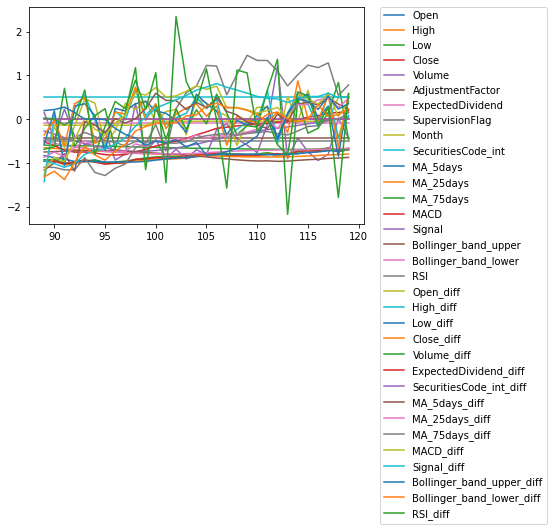

In [26]:
df_base_and_test_proced.plot().legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

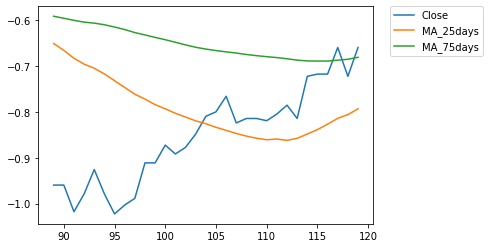

In [27]:
df_base_and_test_proced[['Close', 'MA_25days', 'MA_75days']].plot().legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)